## Bayesian Network

In [ ]:
# Install and load necessary libraries
install.packages("bnlearn")
install.packages("gRbase")
install.packages("GGally")
install.packages("igraph")
library(bnlearn)
library(gRbase)
library(igraph)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘igraph’, ‘Rcpp’, ‘RcppEigen’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘ggstats’, ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, nodes, parents



Attaching package: ‘igraph’


The following objects are masked from ‘package:gRbase’:

    edges, is_dag, topo_sort


The following objects are masked from ‘package:bnlearn’:

    as.igraph, compare, degree, subgraph


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    u

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



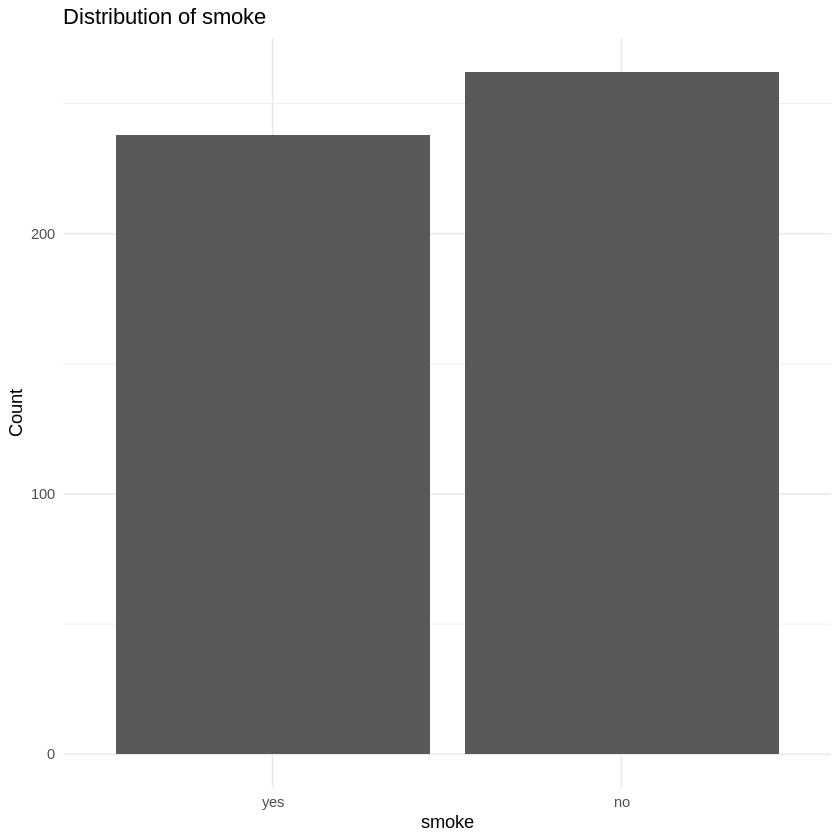

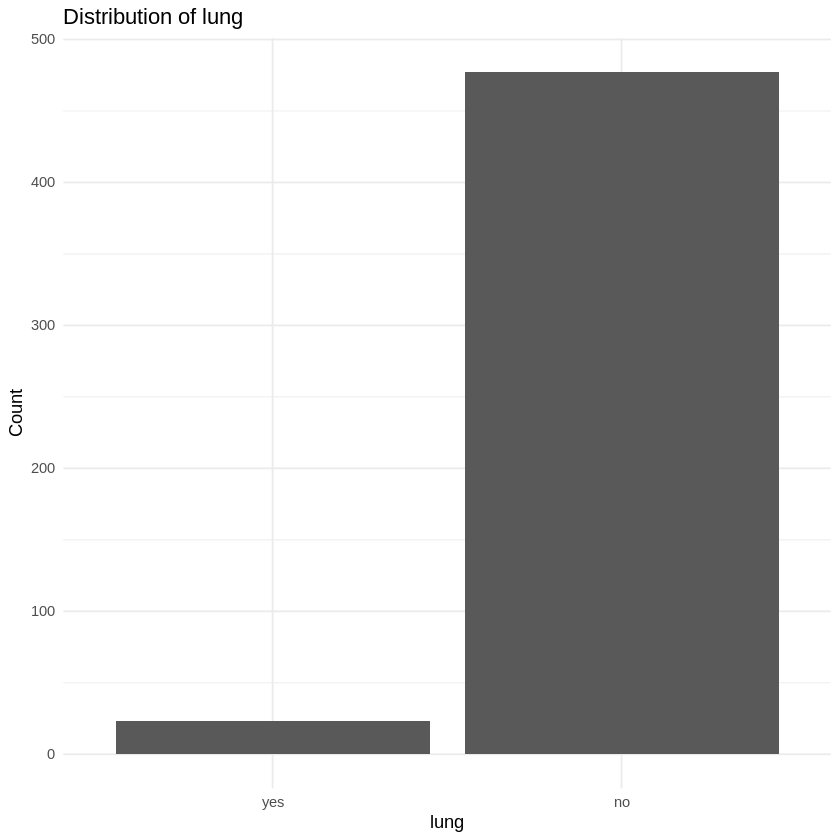

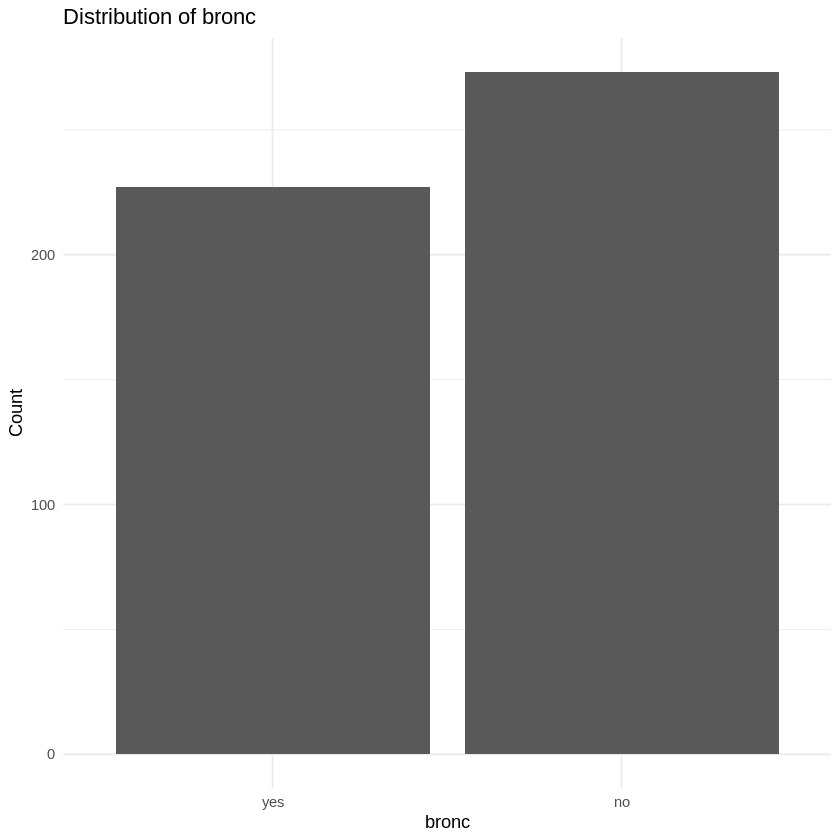

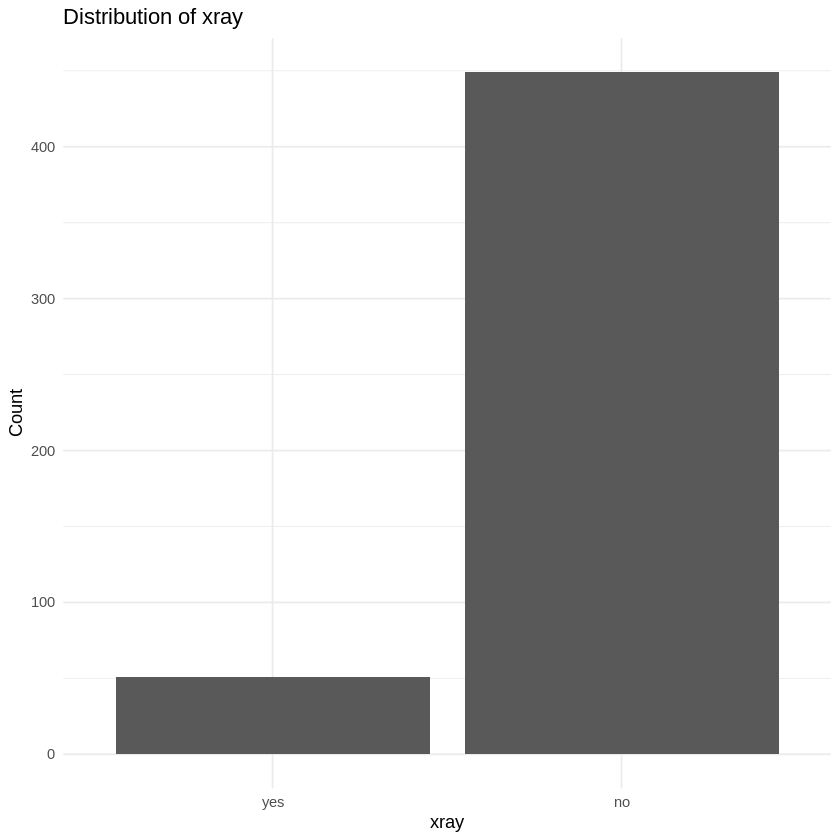

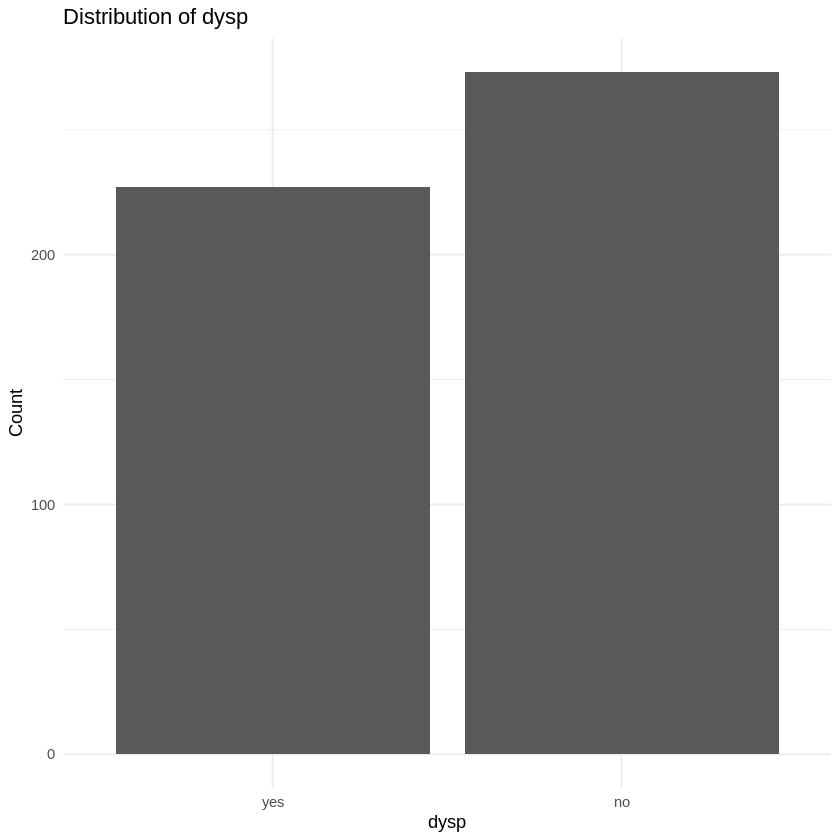

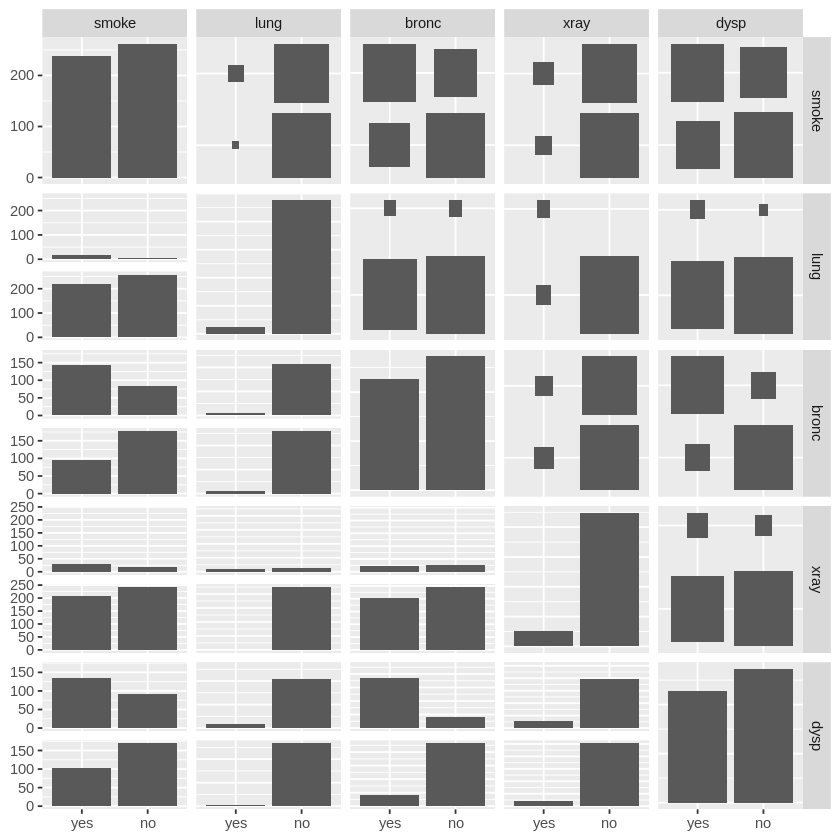

In [ ]:
# Introduction to Bayesian Networks
# A Bayesian Network (BN) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG).
# Nodes in the graph represent random variables, and edges represent conditional dependencies.
# Bayesian Networks are useful because they provide a compact representation of joint probability distributions.
# They allow for efficient reasoning and decision-making under uncertainty, by encoding and utilizing the conditional independencies among variables.
# In this exercise, we will use the 'chestSim500' dataset from the 'gRbase' package.
# This dataset contains 500 simulated cases related to factors influencing dyspnea (difficulty breathing).

# Install and load necessary libraries for visualization
install.packages("ggplot2")
install.packages("GGally")
library(ggplot2)
library(GGally)


# Load the chestSim500 dataset from the gRbase package
data("chestSim500", package = "gRbase")
chest_data <- chestSim500

# Remove the variables 'asia', 'tub', and 'either' from the analysis
chest_data <- chest_data[ , !(names(chest_data) %in% c("asia", "tub", "either"))]

# Convert variables to factors
chest_data <- data.frame(lapply(chest_data, as.factor))

# Generate a blacklist of prohibited arcs, prohibiting arcs from xray to any other variable
# The blacklist must be a data.frame with two columns: 'from' and 'to'
blacklist <- data.frame(
  from = rep("xray", length(setdiff(names(chest_data), "xray"))),
  to = setdiff(names(chest_data), "xray")
)

# Visualizations
# Bar plot for each variable to understand their distribution
for (var in names(chest_data)) {
  print(
    ggplot(chest_data, aes_string(x = var)) +
    geom_bar() +
    labs(title = paste("Distribution of", var), x = var, y = "Count") +
    theme_minimal()
  )
}

# Pairwise plot to visualize the relationships between variables
ggpairs(chest_data)

Warning message in entropy.loss(fitted = fitted, data = data, debug = debug):
“2 observations were dropped because the corresponding probabilities for node dysp were 0 or NaN.”



  k-fold cross-validation for Bayesian networks

  target learning algorithm:             Hill-Climbing 
  number of folds:                       10 
  loss function:                         Log-Likelihood Loss (disc.) 
  number of runs:                        10 
  average loss over the runs:            2.186872 
  standard deviation of the loss:        0.004798844 


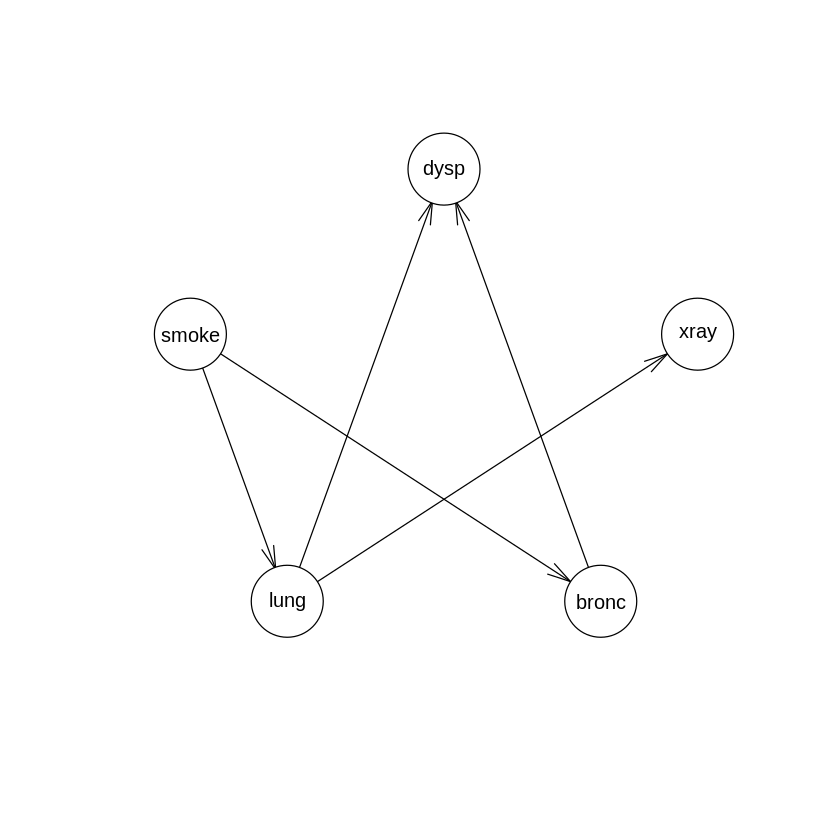

In [ ]:
set.seed(123)
# Structural Learning
# Perform structural learning using the Hill-Climbing (hc) algorithm, including the prohibited arcs specified in the blacklist
# The Hill-Climbing algorithm is a search algorithm that starts with an initial solution and iteratively makes small changes to the structure,
# aiming to improve a scoring function (such as BIC or AIC). It climbs towards the optimal structure by selecting the best neighboring structure.
bn_structure <- hc(chest_data, blacklist = blacklist)

# Cross-Validation
# Cross-validate the learned structure using 10-fold cross-validation, running 10 times
# Cross-validation is a technique used to evaluate the performance of a model by dividing the data into multiple folds.
# In k-fold cross-validation, the data is split into 'k' equally sized folds. The model is trained on 'k-1' folds and tested on the remaining fold.
# This process is repeated 'n' times (runs), with each fold used as the test set once. The performance metrics are averaged over all folds to provide an overall evaluation.
# Here, we use 10-fold cross-validation, meaning the data is split into 10 folds.
# The process is repeated 10 times (10 runs) to ensure robustness and to get a better estimate of the model's performance.
bn.cv(chest_data, bn = "hc", method = "k-fold", k = 10, runs = 10)

# Plot the associated Bayesian network
# The plot function visualizes the learned Bayesian Network structure.
# Nodes represent the variables, and directed edges represent the conditional dependencies between them.
plot(bn_structure)

# The log-likelihood loss function measures the fit of the model to the data, with lower values indicating a better fit.
#
# Number of runs: 10
# The cross-validation process was repeated 10 times to ensure robustness and obtain a reliable estimate of the model’s performance.
# The average loss over the runs is 2.186872, which indicates the average log-likelihood loss across all 10 runs of the 10-fold cross-validation.
# The standard deviation of the loss is 0.004798844, which indicates the variability of the log-likelihood loss across the 10 runs.
# A low standard deviation suggests consistent performance across the runs.

In [ ]:
# Conditional Independence Testing
# Determine if 'xray' and 'dysp' are conditionally independent given 'bronc' and 'lung'
ci_test <- ci.test("xray", "dysp", c("bronc", "lung"), data = chest_data)
print(ci_test)

# The result shows mutual information (mi) = 5.8325 with a p-value = 0.212.
# This is the value of the conditional mutual information. Mutual information measures the dependency between variables.
# A value of 0 indicates total independence. Here, the p-value = 0.212, which is greater than 0.05,
# means there is not enough evidence to reject the null hypothesis of conditional independence.
# In other words, we assume conditional independence between 'xray' and 'dysp', given bronc and lung


	Mutual Information (disc.)

data:  xray ~ dysp | bronc + lung
mi = 5.8325, df = 4, p-value = 0.212
alternative hypothesis: true value is greater than 0



In [ ]:
# Parameter Learning
# Compile and propagate the network to learn the conditional probability distributions (CPDs)
# The bn.fit function takes the learned structure (bn_structure) and the dataset (chest_data)
# and estimates the parameters (CPDs) for each node in the network based on the data.

# Fit the Bayesian Network to the data
fitted_bn <- bn.fit(bn_structure, data = chest_data)

# Print the fitted Bayesian Network to view the learned CPDs
print(fitted_bn)

# Interpretation of the printed results:

# Parameters of node smoke (multinomial distribution)
# The 'smoke' node has two states: 'yes' and 'no'.
# The CPD shows the marginal probabilities for 'smoke':
# P(smoke = yes) = 0.476
# P(smoke = no) = 0.524

# Parameters of node lung (multinomial distribution)
# The 'lung' node's probabilities are conditioned on 'smoke':
# When smoke = yes:
# P(lung = yes | smoke = yes) = 0.07983193
# P(lung = no  | smoke = yes) = 0.92016807
# When smoke = no:
# P(lung = yes | smoke = no) = 0.01526718
# P(lung = no  | smoke = no) = 0.98473282

# Parameters of node bronc (multinomial distribution)
# The 'bronc' node's probabilities are conditioned on 'smoke':
# When smoke = yes:
# P(bronc = yes | smoke = yes) = 0.6008403
# P(bronc = no  | smoke = yes) = 0.3991597
# When smoke = no:
# P(bronc = yes | smoke = no) = 0.3206107
# P(bronc = no  | smoke = no) = 0.6793893

# Parameters of node xray (multinomial distribution)
# The 'xray' node's probabilities are conditioned on 'lung':
# When lung = yes:
# P(xray = yes | lung = yes) = 1.00000000
# P(xray = no  | lung = yes) = 0.00000000
# When lung = no:
# P(xray = yes | lung = no) = 0.05870021
# P(xray = no  | lung = no) = 0.94129979

# Parameters of node dysp (multinomial distribution)
# The 'dysp' node's probabilities are conditioned on 'bronc' and 'lung':
# When bronc = yes and lung = yes:
# P(dysp = yes | bronc = yes, lung = yes) = 0.8181818
# P(dysp = no  | bronc = yes, lung = yes) = 0.1818182
# When bronc = yes and lung = no:
# P(dysp = yes | bronc = yes, lung = no) = 0.8194444
# P(dysp = no  | bronc = yes, lung = no) = 0.1805556
# When bronc = no and lung = yes:
# P(dysp = yes | bronc = no, lung = yes) = 0.6666667
# P(dysp = no  | bronc = no, lung = yes) = 0.3333333
# When bronc = no and lung = no:
# P(dysp = yes | bronc = no, lung = no) = 0.1264368
# P(dysp = no  | bronc = no, lung = no) = 0.8735632


  Bayesian network parameters

  Parameters of node smoke (multinomial distribution)

Conditional probability table:
   yes    no 
0.476 0.524 

  Parameters of node lung (multinomial distribution)

Conditional probability table:
 
     smoke
lung         yes         no
  yes 0.07983193 0.01526718
  no  0.92016807 0.98473282

  Parameters of node bronc (multinomial distribution)

Conditional probability table:
 
     smoke
bronc       yes        no
  yes 0.6008403 0.3206107
  no  0.3991597 0.6793893

  Parameters of node xray (multinomial distribution)

Conditional probability table:
 
     lung
xray         yes         no
  yes 1.00000000 0.05870021
  no  0.00000000 0.94129979

  Parameters of node dysp (multinomial distribution)

Conditional probability table:
 
, , bronc = yes

     lung
dysp        yes        no
  yes 0.8181818 0.8194444
  no  0.1818182 0.1805556

, , bronc = no

     lung
dysp        yes        no
  yes 0.6666667 0.1264368
  no  0.3333333 0.8735632




In [ ]:
# Some Conditional Probabilities
# Assign values of evidence to nodes and calculate the probability of 'dysp' given the evidence
# The cpquery function is used to perform probabilistic inference in the Bayesian Network.
# Here, we are computing P(dysp = "yes" | smoke = "yes", lung = "yes"), which is the probability that dyspnea (dysp) is present
# given that the person smokes (smoke = "yes") and has a lung condition (lung = "yes").
set.seed(1)
evidence <- list(smoke = "yes", lung = "yes")
dysp_prob <- cpquery(fitted_bn, event = (dysp == "yes"), evidence = (smoke == "yes" & lung == "yes"))
print(dysp_prob)

# Query the probability of 'bronc' given 'smoke' and 'dysp'
# The cpquery function is used again to calculate P(bronc = "yes" | smoke = "yes", dysp = "yes"),
# which is the probability that a person has bronchitis (bronc) given that they smoke and have dyspnea.
bronc_prob <- cpquery(fitted_bn, event = (bronc == "yes"), evidence = (smoke == "yes" & dysp == "yes"))
print(bronc_prob)

# Query the joint probability of 'smoke' and 'dysp'
# This calculates the joint probability P(smoke = "yes" and dysp = "yes"), which is the probability that
# both smoking and dyspnea are present in the dataset.
joint_prob <- cpquery(fitted_bn, event = (smoke == "yes" & dysp == "yes"), evidence = TRUE)
print(joint_prob)

[1] 0.7356322
[1] 0.8988593
[1] 0.265


In [ ]:
# Sensitivity Analysis
# Vary the state of 'smoke' and observe its effect on the probability of 'dysp'
evidence_yes <- list(smoke = "yes")
evidence_no <- list(smoke = "no")

dysp_prob_yes_smoke <- cpquery(fitted_bn, event = (dysp == "yes"), evidence = (smoke == "yes"))
dysp_prob_no_smoke <- cpquery(fitted_bn, event = (dysp == "yes"), evidence = (smoke == "no"))

cat("P(dysp = 'yes' | smoke = 'yes') =", dysp_prob_yes_smoke, "\n")
cat("P(dysp = 'yes' | smoke = 'no') =", dysp_prob_no_smoke, "\n")

P(dysp = 'yes' | smoke = 'yes') = 0.5534106 
P(dysp = 'yes' | smoke = 'no') = 0.3529862 


In [ ]:
# Scenario Analysis
# Scenario 1: Given 'smoke' is "yes" and 'lung' is "no", calculate the probability of 'bronc' being "yes"
scenario1_prob <- cpquery(fitted_bn, event = (bronc == "yes"), evidence = (smoke == "yes" & lung == "no"))
print(scenario1_prob)

# Scenario 2: Given 'smoke' is "no" and 'lung' is "yes", calculate the probability of 'bronc' being "yes"
scenario2_prob <- cpquery(fitted_bn, event = (bronc == "yes"), evidence = (smoke == "no" & lung == "yes"))
print(scenario2_prob)

[1] 0.6185897
[1] 0.3695652
